# Batch Normalization

The goal here is to understand various batch normalization techniques on a neural network using the mnist dataset.
- Network with Group Normalization
- Network with Layer Normalization
- Network with L1 + BN

## Batch Normalization Used

Defined  a batch normalization function that takes in batch normalization type (bn_type) and channels.

- Group Normalization - splitting into 2 groups
- Layer Normalization - Using GroupNorm function but using one group
- Batch Normalization - Using the usual nn.BatchNorm2d

Modified the network class to take 2 parameters batch normalization type(bn_type) and dropout(dropout_value).

## Incorporating L1 regularization

Modified the train function to incorporate a configurable loss with flag l1_reg only during training

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
def batch_norm(bn_type,channels):
  if bn_type == 'GN':
    return nn.GroupNorm(2,channels)
  elif bn_type == 'LN':
    return nn.GroupNorm(1,channels)
  elif bn_type == 'BN':
    return nn.BatchNorm2d(channels)

# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,bn_type,dropout_value):
        super(Net, self).__init__()

        self.bn_type = bn_type
        self.dropout = dropout_value
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            batch_norm(self.bn_type,10),
            nn.Dropout(self.dropout)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            batch_norm(self.bn_type,20),
            #nn.Dropout(self.dropout)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) 

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,20),
            nn.Dropout(self.dropout)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,12),
            #nn.Dropout(self.dropout)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,12),
            nn.Dropout(self.dropout)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,16),
            nn.Dropout(self.dropout)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(self.dropout)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('GN',0.1).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         GroupNorm-7           [-1, 20, 24, 24]              40
            Conv2d-8           [-1, 10, 24, 24]             200
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
             ReLU-11           [-1, 20, 10, 10]               0
        GroupNorm-12           [-1, 20, 10, 10]              40
          Dropout-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch,l1_reg):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    if l1_reg:
      L1_reg = torch.tensor(0., requires_grad=True)
      for name, param in model.named_parameters():
        if 'weight' in name:
          L1_reg = L1_reg + torch.norm(param, 1)
      
      loss = F.nll_loss(y_pred, target) + 10e-4 * L1_reg  
    else :  
      loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

    #return train_acc, train_losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    #return test_acc, test_loss

In [9]:
def display_misclassified_images(model):
  print("\n\n\n********* Misclassified Images **************\n\n\n")
  model.eval()

  # Create a test loader with batch size equal to test data length
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          # Get the indexes of images that are incorrectly classified
          indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

          # Plot the misclassified images
          rows = np.ceil(len(indexes)/2)
          fig = plt.figure(figsize=(15, rows*4))
          for i, idx in enumerate(indexes[:10]):
              ax = fig.add_subplot(rows, 5, i+1)
              ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r')
              ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")
          
          plt.show()

In [10]:
def train_test_display(bn_type, no_of_epochs,l1_reg):

  model =  Net(bn_type,0.1).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  #scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  # LR Scheduler
  lambda1 = lambda epoch: 0.85 ** epoch
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

  for epoch in range(1,no_of_epochs):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,l1_reg)
      scheduler.step()
      test(model, device, test_loader)
  
  display_misclassified_images(model)

  return test_acc, test_losses,train_acc,train_losses

In [11]:
EPOCHS = 16





# **Using Batch Normalization**

  0%|          | 0/469 [00:00<?, ?it/s]




********* Using Batch Normalization **************



EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.5297030806541443 Batch_id=468 Accuracy=90.65: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1631, Accuracy: 9517/10000 (95.17%)

EPOCH: 2


Loss=0.43051677942276 Batch_id=468 Accuracy=95.28: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1102, Accuracy: 9641/10000 (96.41%)

EPOCH: 3


Loss=0.4323696196079254 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1131, Accuracy: 9646/10000 (96.46%)

EPOCH: 4


Loss=0.4455043077468872 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0956, Accuracy: 9689/10000 (96.89%)

EPOCH: 5


Loss=0.3680935800075531 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3376, Accuracy: 9008/10000 (90.08%)

EPOCH: 6


Loss=0.41582822799682617 Batch_id=468 Accuracy=96.31: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0840, Accuracy: 9742/10000 (97.42%)

EPOCH: 7


Loss=0.38767099380493164 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0934, Accuracy: 9700/10000 (97.00%)

EPOCH: 8


Loss=0.3757140636444092 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0933, Accuracy: 9703/10000 (97.03%)

EPOCH: 9


Loss=0.3215290904045105 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0740, Accuracy: 9769/10000 (97.69%)

EPOCH: 10


Loss=0.33441734313964844 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Accuracy: 9668/10000 (96.68%)

EPOCH: 11


Loss=0.2718867361545563 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0813, Accuracy: 9752/10000 (97.52%)

EPOCH: 12


Loss=0.4100320637226105 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9692/10000 (96.92%)

EPOCH: 13


Loss=0.36629223823547363 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0876, Accuracy: 9731/10000 (97.31%)

EPOCH: 14


Loss=0.22843793034553528 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0794, Accuracy: 9763/10000 (97.63%)

EPOCH: 15


Loss=0.25654441118240356 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]



Test set: Average loss: 0.0533, Accuracy: 9833/10000 (98.33%)




********* Misclassified Images **************





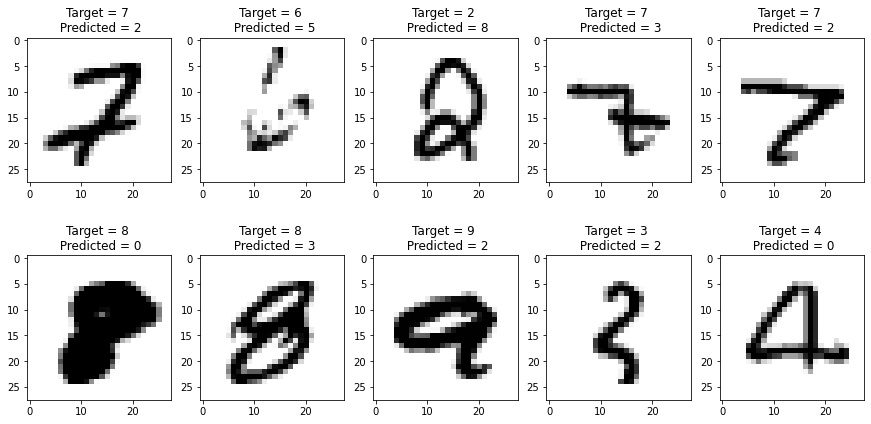

In [12]:
print("\n\n\n********* Using Batch Normalization **************\n\n\n")
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_acc_bn, test_losses_bn,train_acc_bn,train_losses_bn = train_test_display('BN', EPOCHS,l1_reg = True)


# **Using Layer Normalization**

  0%|          | 0/469 [00:00<?, ?it/s]




********* Using Layer Normalization **************



EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.10824477672576904 Batch_id=468 Accuracy=88.82: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Accuracy: 9774/10000 (97.74%)

EPOCH: 2


Loss=0.028674712404608727 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.1441277414560318 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.016932200640439987 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.08651440590620041 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.10945385694503784 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.027208561077713966 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.004790606442838907 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.005999330896884203 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.00930878147482872 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.04827431961894035 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.04318062588572502 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:20<00:00, 22.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.016330057755112648 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.002405887935310602 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.07643813639879227 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]



Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)




********* Misclassified Images **************





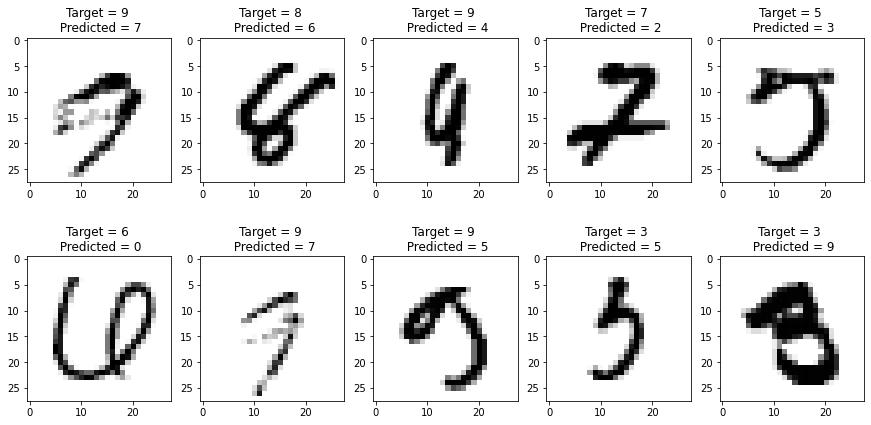

In [13]:
print("\n\n\n********* Using Layer Normalization **************\n\n\n")
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_acc_ln, test_losses_ln,train_acc_ln,train_losses_ln = train_test_display('LN', EPOCHS,l1_reg = False)

# **Using Group Normalization**

  0%|          | 0/469 [00:00<?, ?it/s]




********* Using Group Normalization **************



EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.10228031873703003 Batch_id=468 Accuracy=89.39: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9802/10000 (98.02%)

EPOCH: 2


Loss=0.05452302098274231 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.11945565789937973 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.022680334746837616 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.007362309843301773 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.024925462901592255 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.025248268619179726 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.010129885748028755 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.069411501288414 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.009411086328327656 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.02434828132390976 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.011211756616830826 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.05625396594405174 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.07997368276119232 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.0673392042517662 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]



Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)




********* Misclassified Images **************





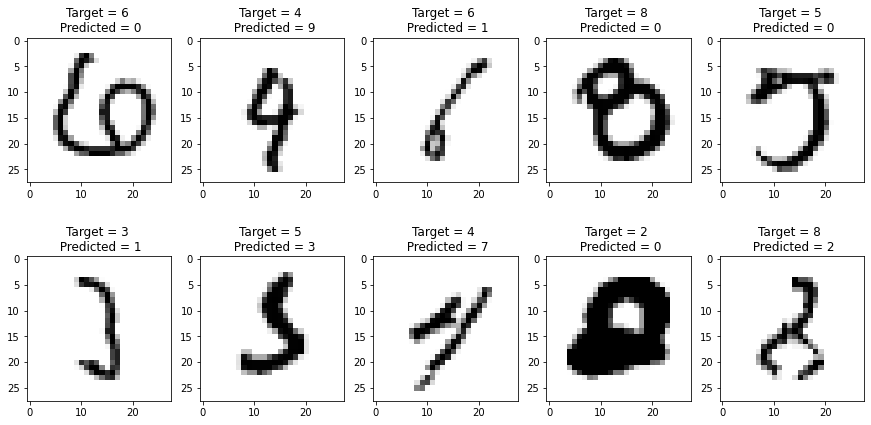

In [14]:
print("\n\n\n********* Using Group Normalization **************\n\n\n")
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_acc_gn, test_losses_gn,train_acc_gn,train_losses_gn = train_test_display('GN', EPOCHS,l1_reg = False)

# **Let's Plot graphs**



Text(0.5, 1.0, 'Test Accuracy')

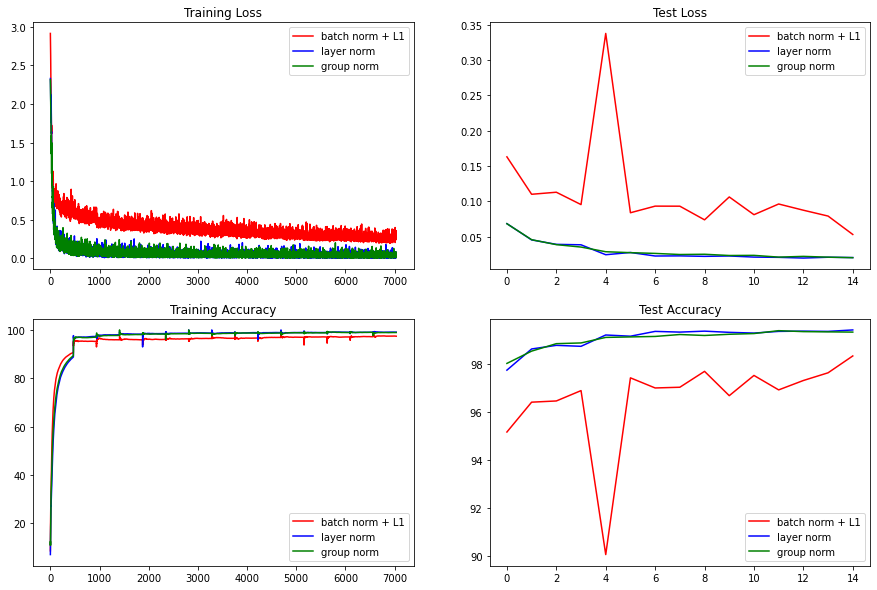

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs =[x for x in range(7035)]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(epochs,train_losses_bn,'-r',label='batch norm + L1')
axs[0, 0].plot(epochs,train_losses_ln,'-b',label='layer norm')
axs[0, 0].plot(epochs,train_losses_gn,'-g',label='group norm')
axs[0, 0].legend(loc="upper right")
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(epochs,train_acc_bn,'r',label='batch norm + L1')
axs[1, 0].plot(epochs,train_acc_ln,'b',label='layer norm')
axs[1, 0].plot(epochs,train_acc_gn,'g',label='group norm')
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Training Accuracy")

epochs =[x for x in range(15)]
axs[0, 1].plot(epochs,test_losses_bn,'r',label='batch norm + L1')
axs[0, 1].plot(epochs,test_losses_ln,'b',label='layer norm')
axs[0, 1].plot(epochs,test_losses_gn,'g',label='group norm')
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(epochs,test_acc_bn,'r',label='batch norm + L1')
axs[1, 1].plot(epochs,test_acc_ln,'b',label='layer norm')
axs[1, 1].plot(epochs,test_acc_gn,'g',label='group norm')
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Accuracy")